# Spherical Cap Mesh

In this notebook, we will see how to create a spherical cap mesh, give it some thickness and then add the information of basis vectors to its vertices.

After that we will visualize them, measure curvature to verify that it is constant throughout.

In [10]:
from methods import *

mesh_refine_factor = 30
output_pickle = f"pickle/IcoSph_mesh_refine_factor_{mesh_refine_factor}.pkl"
output_file = f"vtk/IcoSph_mesh_refine_factor_{mesh_refine_factor}.ply"
try:
    [sphere_balls_df,sphere_edges_df,sphere_cells_df] = pickle.load(open(output_pickle,"rb"))
except:
    [sphere_balls_df,sphere_edges_df,sphere_cells_df] = get_meshzoo_icosa_sphere(refine_factor = mesh_refine_factor,
                                                                                 output_pickle = output_pickle, 
                                                                                 output_file = output_file
                                                                                )


In [19]:
thickness = 0.1
angle_of_rotation = 0.1
theta_max = 0.8662
theta_DV = 3.14 #set 0.1931 as measured from data #set 3.14 if throughout you want DV boundary #set 0 if no DV boundary
R = 1

In [20]:
output_pickle = f"pickle/IcoSph_mesh_wo_basis_vectors_refine_factor_{mesh_refine_factor}_thickness_{thickness}_angle_of_rotation_{angle_of_rotation}_theta_max_{theta_max}.pkl"
output_file = f"vtk/IcoSph_mesh_wo_basis_vectors_refine_factor_{mesh_refine_factor}_thickness_{thickness}_angle_of_rotation_{angle_of_rotation}_theta_max_{theta_max}.vtk"
try:
    [balls_df, springs_df] = pickle.load(open(output_pickle,"rb"))
except:
    thickness_polynomial_coeffs = np.array([1])*thickness
    thickness_polynomial_obj = np.poly1d(thickness_polynomial_coeffs)

    [balls_df, springs_df] = add_thickness_to_mesh(v_df = sphere_balls_df[['x', 'y', 'z']], edges_df = sphere_edges_df, #cells_df = cells_df,
                                                               thickness_polynomial_obj = thickness_polynomial_obj,
                                                               rotate_mesh_bool=True, angle_of_rotation = angle_of_rotation,
                                                               crop_mesh_bool=True, theta_max=theta_max,
                                                               output_pickle = output_pickle, 
                                                               output_vtk = output_file,
                                                              )

In [21]:
#add basis vectors to mesh
output_pickle = f"pickle/IcoSph_mesh_w_basis_vectors_refine_factor_{mesh_refine_factor}_thickness_{thickness}_angle_of_rotation_{angle_of_rotation}_theta_max_{theta_max}_theta_DV_{theta_DV}.pkl"
try:
    [balls_df, springs_df] = pickle.load(open(output_pickle,"rb"))
except:
    #add basis vectors
    [balls_df, springs_df] = add_basis_vectors_to_Sph(balls_df, springs_df, theta_DV=theta_DV)
    #save
    pickle.dump([balls_df,springs_df], open(output_pickle, 'wb'))
    

In [22]:
#modify thickness
#we can modify the thicknes off the mesh if we want
thickness = 0.2
bottom_ind = np.arange(int(len(balls_df)/2)) #bottom_index
top_ind = bottom_ind + len(bottom_ind)
balls_df.loc[bottom_ind,["x","y","z"]] =  balls_df.loc[top_ind, ["x","y","z"]].values - (thickness*balls_df.loc[top_ind, ["e_h_x","e_h_y","e_h_z"]]).values
springs_df = update_springs(springs_df, balls_df[['x', 'y', 'z']])
#save mesh
#pickle.dump([balls_df, springs_df], open(dirname+'runfiles/init_mesh.pickle', 'wb'))


# Visualization
Top View

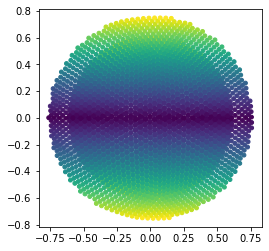

In [23]:
%matplotlib inline
fig,ax = plt.subplots(figsize = (4,4))
_=ax.scatter(balls_df["x"], balls_df["y"], s = 15, c = balls_df["pathlength_scaled"])
#plotting the DV boundary
#_=ax.axvline(x = R*np.sin(theta_DV/2), color = "black", linewidth = 5)
#_=ax.axvline(x = -R*np.sin(theta_DV/2), color = "black", linewidth = 5)
#ax.axhline(y = 0, color = "black", linewidth = 5)
_=ax.axis("equal")

We can use pyvista to visualize somethings like the basis vectors. The package is also useful for computing quantities like the Gaussian and Mean curvatures.

In [24]:
#extract just one layer from the thick mesh
[top_balls, top_springs] = extract_thin_mesh(balls_df, springs_df, which = "top", reindex = True)
#convert to Pyvista mesh
mesh = dfToPyvista(top_balls, top_springs)
#add basis vectors
mesh["e_h"] = top_balls[["e_h_x", "e_h_y", "e_h_z",]]
mesh["e_R"] = top_balls[[ "e_R_x", "e_R_y", "e_R_z",]]
mesh["e_phi"] = top_balls[["e_phi_x", "e_phi_y", "e_phi_z",]]
#scalar : normalized pathlength from the center
mesh["pathlength_scaled"] = top_balls["pathlength_scaled"]
#if particle in DV boundary then DV_bool = 1 otherwise 0
mesh["DV_bool"] = top_balls["DV_bool"]
#
mesh["gauss_curv"] = mesh.curvature(curv_type="gaussian")
mesh["mean_curv"] = mesh.curvature(curv_type="mean")

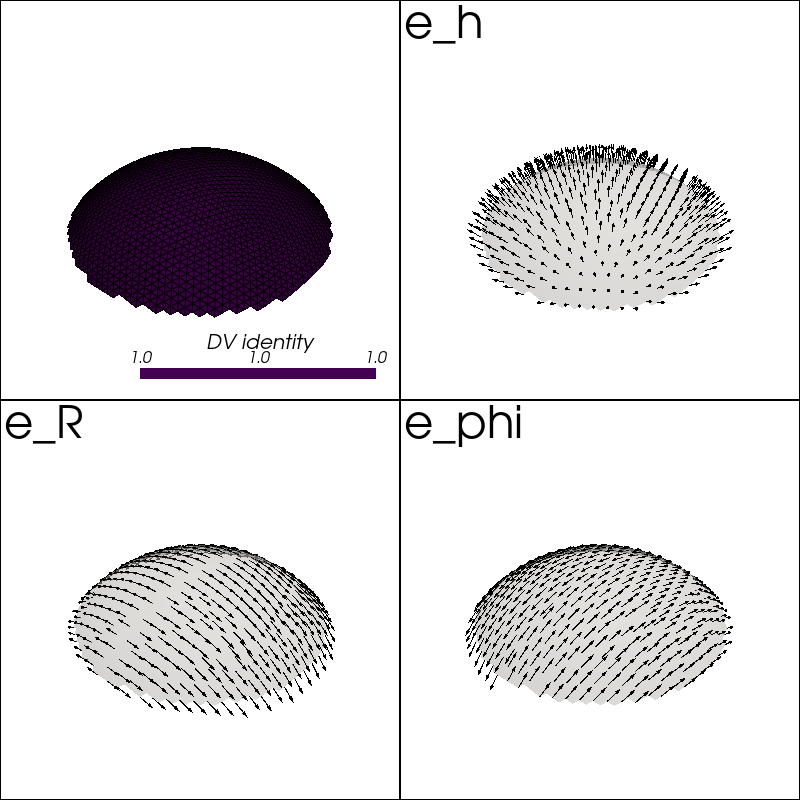

In [25]:
%matplotlib inline

def helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 800, tolerance = 0.03,):
    #display_args = dict(show_edges=True, color=True, line_width= 0.001)
    
    p = pv.Plotter(shape=vector_names.shape, window_size=[vector_names.shape[1]*window_scale, vector_names.shape[0]*window_scale])
    
    def single_plot(i,j,vector_name):
        p.subplot(i,j)
        if vector_name is None: 
            return p
        mesh["vector_scaled"] = mesh[vector_name]*scale_for_vis
        mesh.set_active_vectors("vector_scaled")
        arrows = mesh.glyph(scale="vector_scaled", orient="vector_scaled", tolerance=tolerance)
        p.add_mesh(arrows, lighting=False,show_scalar_bar=False, color = "black",)
        #p.add_mesh(surf.arrows, lighting=False,show_scalar_bar=False,)
        p.add_mesh(mesh, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
        p.add_text(vector_name, color = "black")

    for i in range(vector_names.shape[0]):
        for j in range(vector_names.shape[1]):
            single_plot(i,j,vector_names[i,j])
            
    return p

# put the vector names in the matrix form of how you would like the subplots
vector_names = np.matrix([[None, "e_h"],
                          ["e_R", "e_phi"]
                         ])
p = helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 400, tolerance = 0.03)

#We left the top left plot empty
#We add just the mesh coloring it by a scalar like the identity of DV boundary
p.subplot(0,0)
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = 'DV identity',
)
mesh.set_active_scalars("DV_bool")
p.add_mesh(mesh, show_edges=True,scalar_bar_args=sargs,interpolate_before_map=False, opacity=1)
p.background_color = "white"
p.show(screenshot='test.png') #saving does not seem to work


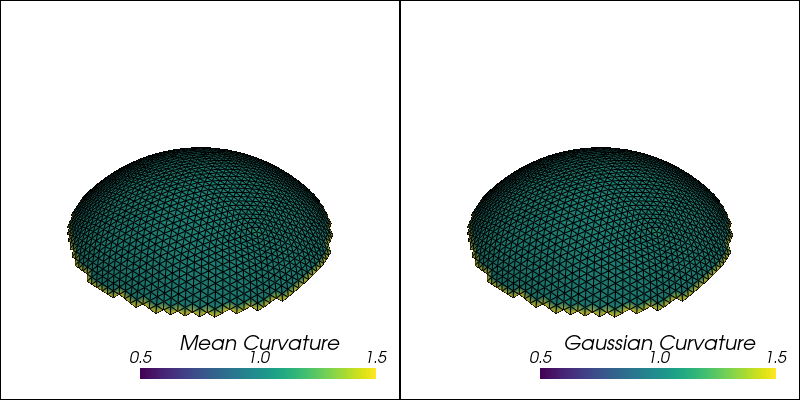

In [26]:
window_scale = 400
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True, vertical = False, #height=0.25, position_x=0.05, position_y=0.05
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = "Mean Curvature",
)

p = pv.Plotter(shape=(1,2), window_size=[2*window_scale, window_scale])

#mean curvature
p.subplot(0,0)
mesh.set_active_scalars("mean_curv")
p.add_mesh(mesh, clim=[0.5, 1.5], show_edges=True,scalar_bar_args=sargs,interpolate_before_map=False, opacity=1)
p.background_color = "white"

#gaussian curvature
p.subplot(0,1)
mesh.set_active_scalars("gauss_curv")
sargs["title"] = "Gaussian Curvature"
p.add_mesh(mesh, clim=[0.5, 1.5], show_edges=True, scalar_bar_args=sargs,interpolate_before_map=False, opacity=1)
p.background_color = "white"

p.show(screenshot='plots/test.png')
